In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib
matplotlib.style.use('seaborn')

from draftbot import Draft
from itertools import repeat

In [2]:
import json

card_values = pd.DataFrame(json.load(open('data/m19-custom-card-values-reduced.json'))).T

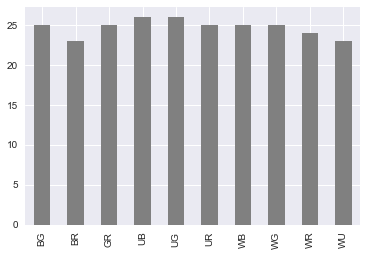

In [3]:
card_values.sum().plot.bar(color='grey')

In [4]:
draft = Draft(cards_path='data/m19-subset-reduced.json',
              card_values_path='data/m19-custom-card-values-reduced.json')
draft.draft()

/Users/matthewdrury/Projects/mtg-draft-bot/draftbot.py:159: RuntimeWarning: invalid value encountered in true_divide
  probs = exps / row_sums.reshape(-1, 1)
/Users/matthewdrury/Projects/mtg-draft-bot/draftbot.py:103: RuntimeWarning: invalid value encountered in less
  pick_idx = np.random.choice(self.set.n_cards, p=row)


## Assemble Some More Convenient Data Structures

In [5]:
preferences_history_dfs = []

for drafter_idx in range(draft.n_drafters):
    preferences_history_dfs.append(
        pd.DataFrame(
            draft.preferences_history[drafter_idx, :, :].T,
            columns=draft.archetype_names))

In [6]:
cards_picked = []
for i in range(8):
    df = pd.DataFrame(draft.picks[i, :, :].astype(int).T, columns=draft.card_names)
    cards_picked.append(df.idxmax(axis=1))

## Plotting Code

In [15]:
def make_archytype_color_mapping(alpha):
    arch_color_mapping = {
        'W': [1, 0.8, 0.5, alpha],
        'U': [0.2, 0.2, 1, alpha],
        'B': [0.2, 0.2, 0.2, alpha],
        'R': [1, 0, 0, alpha],
        'G': [0, 0.8, 0, alpha]
    }
    return arch_color_mapping

rarity_color_mapping = {
    'common': [0.0, 0.0, 0.0],
    'uncommon': [192 / 255, 192 / 255, 192 / 255],
    'rare': [255 / 255, 215 / 255, 0],
    'mythic': [255 / 255, 140 / 255, 0],    
}

def make_archytype_colors(arch, alpha=1):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    return [arch_color_mapping[c] for c in arch]

card_color_mapping = {
    card['name']: card['colorIdentity'] for card in draft.set.cards
}

card_rarity_mapping = {
    card['name']: card['rarity'] for card in draft.set.cards
}

In [16]:
def plot_alternating_color_line(ax, x, y, colors):
    x, y = insert_middpoints(x.astype(float)), insert_middpoints(y.astype(float))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segment_boundaries = insert_middpoints(np.arange(x.min(), x.max() + 1))
    n_bins = len(segment_boundaries) - 1
    cmap = ListedColormap((colors*n_bins)[:n_bins])
    norm = BoundaryNorm(segment_boundaries, cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)

def insert_middpoints(arr):
    midpoints = (arr[:-1] + arr[1:]) / 2
    return np.insert(arr, np.arange(1, len(arr)), midpoints)

In [17]:
def plot_color_identity_dot(ax, x, y, color_identity, s=100, alpha=1.0):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    colors = [arch_color_mapping[c] for c in color_identity]
    if len(colors) == 0:
        ax.scatter(x, y, c=['grey'], s=s, zorder=2)
    if len(colors) == 1:
        ax.scatter(x, y, c=[colors[0]], s=s, zorder=2)
    if len(colors) >= 2:
        plot_multi_color_dot(ax, x, y, colors)

def plot_multi_color_dot(ax, x, y, colors, s=100):
    angles = list(np.linspace(start=0, stop=2*np.pi, num=(len(colors) + 1)))
    begin_angles = angles[:-1]
    end_angles = angles[1:]
    for angle, end_angle, color in zip(begin_angles, end_angles, colors):
        xs = [0] + np.sin(np.linspace(angle, end_angle, 25)).tolist()
        ys = [0] + np.cos(np.linspace(angle, end_angle, 25)).tolist()
        xy = np.column_stack([xs, ys])
        ax.scatter(x, y, marker=xy, s=s, facecolor=color, zorder=2)

In [18]:
def softmax(df):
    return pd.DataFrame(
         np.exp(df).values / np.exp(df).sum(axis=1).values.reshape(-1, 1),
         columns=df.columns)

def normalize(df):
    return pd.DataFrame(
        df.values / df.sum(axis=1).values.reshape(-1, 1),
        columns=df.columns)

In [35]:
def plot_history_lines(ax, 
                       history_df, 
                       normalization_function=softmax, 
                       winning_archytype=None):
    history_df = normalization_function(history_df)
    if not winning_archytype:
        winning_archytype = history_df.iloc[-1, :].idxmax()
    winning_history = history_df.loc[:, winning_archytype]
    
    colors = make_archytype_colors(winning_archytype, alpha=1.0)
    plot_alternating_color_line(
        ax, 
        winning_history.index.values, 
        winning_history.values, 
        colors)
    
    for arch in set(history_df.columns) - set([winning_archytype]):
        arch_history = history_df.loc[:, arch]
        colors = make_archytype_colors(arch, alpha=0.2)
        plot_alternating_color_line(
            ax,
            arch_history.index.values,
            arch_history.values, colors)
    
    return winning_archytype, winning_history

def plot_drafter_history(ax,
                         history_df,
                         cards_picked,
                         normalization_function=softmax):
    
    winning_archytype, winning_history = plot_history_lines(
        ax,
        history_df,
        normalization_function=normalization_function)
    
    card_rarities = [card_rarity_mapping[card] for card in cards_picked]
    card_colors = [card_color_mapping[card] for card in cards_picked]
    dot_data = zip(
        card_colors, 
        card_rarities, 
        winning_history.index.values,
        winning_history.values[:-1])
    for pick_num, (color_pair, rarity, x, y) in enumerate(dot_data):
        ax.scatter(x, y, s=170, c=[rarity_color_mapping[rarity]])
        plot_color_identity_dot(ax, x, y, color_pair)
        if pick_num % 14 == 1:
            ax.axvline(pick_num, linestyle='--', alpha=0.5)
    
    return winning_archytype, winning_history

(-0.1, 1.1)

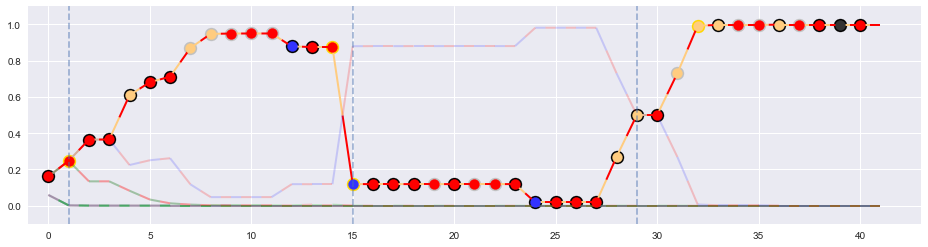

In [37]:
fig, ax = plt.subplots(figsize=(16, 4))

plot_drafter_history(ax, 
                     preferences_history_dfs[5],
                     cards_picked[5], 
                     normalization_function=softmax)
ax.set_xlim(-1, 43)
ax.set_ylim(-0.1, 1.1)

In [ ]:
fig, axs = plt.subplots(8*2, 1, figsize=(16, 20*2))

for (ax1, ax2), drafter in zip(zip(axs[::2], axs[1::2]), drafters):
    
    winning_archytype, _ = plot_drafter_history(ax1, drafter)
    
    plot_history_lines(
        ax2,
        drafter.archytype_power_seen_history, 
        winning_archytype=winning_archytype,
        normalization_function=normalize)
    ax1.set_xlabel("Pick Number")
    ax1.set_ylabel("Color Pair Preference")
    
    ax1.set_xlim(-1, 43)
    ax2.set_xlim(-1, 43)

    ax1.set_ylim(-0.1, 1.1)
    ax2.set_ylim(0.05, 0.2)
    
fig.tight_layout()